<hr>
<h1> Regressão Logística Aplicada ao SASD Memory Effect </h1>
<hr>

<h2><strong>Resumo</strong></h2>
Utilizando variáveis que são pertinentes ao SASD memory effect e ao clima regional do estado de São Paulo, montamos um modelo de regressão logística para predizer o sinal das anomalias de temperatura entre Junho e Agosto, com aproximadamente um ano de antecedência. Esse modelo estatístico apresentou, dentro do conjunto de treinamento, valores de acurácia, precisão e recall de aproximadamente 70%. Notamos que, embora ENSO e SASD sejam conhecidos por seus efeitos no clima regional sobre o continente sulamericano, o modelo apontou para o SASD ocorrido no ano anterior como seu principal componente preditivo. Isso indica a importância do SASD memory effect para o clima regional do sudeste brasileiro e seu real potencial na aplicação como indicador preditivo.


<h2><strong>Introdução</strong></h2>


Sobre o SASD Memory Effect:

Existe um padrão de variabilidade acoplada chamado Dipolo Subtropical do Atlântic Sul (SASD, do inglês) que conecta a variabilidade atmosférica (variabilidade da Alta Subtropical) com a variabilidade das anomalias de temperatura da superfície do mar (TSM) no Atlântico Sul.

Santis et al. 2020 descreveu que, quando um evento de SASD ocorre durante o inverno-primavera, existe um processo oceânico que armazena as anomalias de TSM, que no ano seguinte retornam à superfície. Esse processo constitui um efeito de memória ao SASD.

Muito bem. O efeito de memória traz imediatamente a idéia de previsibilidade. Seria possível então, dado um evento de SASD na época certa, prever que no ano seguinte observaremos condições específicas. Posteriormente, os mesmos autores mostraram que as anomalias de TSM que retornam no ano seguinte (efeito de memória) impactam na atmosfera. Especificamente, anomalias de temperatura do ar próximo à superfície são observadas no estado de São Paulo, e estão associadas ao efeito de memória. Vamos aqui aplicar um modelo de regressão logística no SASD memory effect, com o intuito de prever a probabilidade de, dado um evento de SASD num determinado inverno-primavera, observarmos anomalias quentes ou frias sobre o estado de São Paulo, no inverno do ano subsequente.

<h3> Sobre a Regressão Logística:

A regressão logistica nos oferece um modelo regressor para variáveis categóricas, que não pertencem necessariamente ao conjunto dos números Reais. Exemplos são Y = (SIM , NÃO), Y = (0 , 1), Y = (Sucesso , Fracasso) etc. A regressão nos dá a verossimilhança de um conjunto de variáveis independentes resultarem em uma determinada classe dos valores possíveis de Y. O ajuste se dá com o uso da função sigmoidal, dada por:

Função de ajuste: $\hat{y} = \sigma = \frac{1}{1+e^{-z}}$

Onde:
<li>$z=\beta^T X $
<li>$\beta= \beta_0, \beta_1 , \beta_2, ..., \beta_n $ são coeficientes da função de ajuste</li>
<li>$X= X_1 , X_2 , ..., X_n $ são as variáveis independentes</li>
<li>$\beta^T X= \beta_0+ \beta_1 X_1 , \beta_2 X_2 , ..., \beta_n X_n $ são as variáveis independentes</li>


<li>$\hat{y}$ é a probabilidade do evento pertencer à classe Y=1, dado a observação contida em X</li>

<h1> Objetivo do Estudo: </h1>

Aplicar o modelo de Regressão Logística</strong> ao SASD memory effect, para verificarmos se conseguimos predizer o sinal das anomalias de temperatura sobre São Paulo, entre Junho e Julho, com cerca de um ano de antecedência.

Assim, temos:

- Y = sinal da anomalia de temperatura do ar sobre o estado de São Paulo (aproximadamente), tomada entre Junho e Agosto;

    Defino Y=0 para anomalias negativas, e Y=1 para anomalias positivas;

<h2> É preciso estabelecer quais variáveis ($X$) são relevantes ao problema.</h2>
<li><h3> Vamos elencar inicialmente três variáveis independentes: </li>
   

<li>$X_1$: SASDIy0[julho ano 0], precursora do efeito de memória;</li>
<li>$X_2$: SASDIy1[julho ano 1];</li>
<li>$X_3$: ENSO[julho ano 1];</li>

- SASDI é uma medida do SASD (SASD Index), e é o prinpical índice envolvido no efeito de memória. O SASDI é medido como a diferença das anomalias entre cada pólo do dipolo (polo sudoeste menos polo nordeste);
- ENSO é o índice do El Nino - Oscilação Sul, e é incluído por seus conhecidos impactos no clima regional sulamericano;
- SASD no ano 1 também é incluído, pois também pode influenciar o valor de Y;

<strong>IMPORTANTE</strong> notar que: SASDIy0 é tomado em julho de um determinado ano (ano 0), enquanto que Y, SASDIy1 e ENSO são tomados entre junho e agosto do ano seguinte (ano 1). Há, portanto, aproximadamente um ano de diferença entre SASDIy0 e Y.

<hr>
<h2>Vamos lá! Mãos à obra!

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, confusion_matrix, auc

Função para abrir os arquivos netcdf.



In [2]:
def openfiles():
    # Dados começam todos em 15 jan 1980.
    Sdata= xr.open_dataset('data/MEAN_SASDb.nc')
    Edata= xr.open_dataset('data/Nino3b_ERv5.nc')
    Tdata= xr.open_dataset('data/TSP_anom.nc')
    sasdi=np.array(Sdata['MEDIAB'][:])
    nino3=np.array(Edata['NINO3B'][:])
    #p1=np.array(Pdata['PREC01'][:])
    #p2=np.array(Pdata['PREC02'][:])
    tanom=np.array(Tdata['TANOM'][:])
    return sasdi,nino3,tanom

In [3]:
sasda,ninoa,tanoma=openfiles()

<hr>
Agora extraio SASDIy0 em Julho (ano 0), SASDy1 e NINO em Julho (ano 1) e Tanom entre Junho e Agosto (ano 1).

Em seguinda, transformo tanom (Real) em binário (0,1), e armazeno as variáveis em df.

In [4]:
#nino=np.array([  np.mean(ninoa[i])  for i in range(6,29*12,12)   ])
sasdi=np.array([ np.mean(sasda[i,0]) for i in range(6,29*12,12) ])
sasdiy1=np.array([ np.mean(sasda[i,0]) for i in range(18,30*12,12) ])
nino=np.array([  np.mean(ninoa[i])  for i in range(18,30*12,12)   ])
tanom=np.array([ np.mean(tanoma[i:i+3])  for i in range(17,30*12,12)  ])
Y= np.where(tanom > 0, 1, np.where(tanom < 0, 0,0))
df = pd.DataFrame({'SASDIy0':sasdi,'SASDIy1':sasdiy1,'NINO3':nino,'Tanom':Y})
df.head()

,SASDIy0,SASDIy1,NINO3,Tanom
0,0.409665,0.704473,0.105497,0
1,0.704473,0.486211,1.493417,1
2,0.486211,0.053430,1.443571,0
3,0.053430,-0.496144,-0.024716,1
4,-0.496144,-0.309282,-0.349978,0


In [5]:
def initiate():
    n_features = len(df.columns)-1 
    X = np.array(df.drop('Tanom',1)) 
    y = df.iloc[:,n_features:n_features+1].values
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return n_features, X, y

Importante adicionar o $X_0$ em X. Faço isso com a função abaixo:

In [6]:
def insert_ones(X):
    ones = np.ones([X.shape[0],1])
    return np.concatenate((ones,X),axis=1)

Vamos definiar a função sigmoid, que será ajustada aos dados por meio da técnica da descida do gradiente

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Inicializo w, que contém os coeficientes ($\beta_0$,$\beta_1$ ... ) do ajuste.

<h3>A função custo é dada por:<h3>
    
    
$Custo=\frac{1}{N}\sum_{i=1}^{N}-y_i \log(\hat{y_i})-(1-y_i)\log(1-\hat{y_i})$



In [8]:
def fcusto(w, X, y):    
    
    m = len(X)
    
    parte1 = np.multiply(-y, np.log(sigmoid(X @ w.T)))
    parte2 = np.multiply((1 - y), np.log(1 - sigmoid(X @ w.T)))
    
    somatorio = np.sum(parte1 - parte2)
    
    return  somatorio/m

<hr>
Vou otimizar os coeficientes do ajuste através da técnica da <strong> Descida do Gradiente</strong>, que basicamente faz pequenos incrementos em cada coeficiente de acordo com sua influência no erro (Custo). Caso um incremento positivo em, digamos, $w_0$, represente uma redução no erro, mantendo-se todos os outros coeficientes constantes, então $w_0$ receberá um aumentado com uma fração ($\alpha$) desse incremento.

In [9]:
def gradient_descent(w,X,y,alpha,nsteps):
    cost = np.zeros(nsteps)
    for i in range(nsteps):
        w = w - (alpha/len(X)) * np.sum((sigmoid(X @ w.T) - y)*X, axis=0)
        cost[i] = fcusto(w, X, y)
    
    return w,cost

<hr> Separo os dados em X (independentes) e y (dependente), normalizo X e dou a condição inicial de w (coeficientes). 

In [10]:
n_features, X, y = initiate()
w = np.random.rand(1,n_features+1) ## valores entre 0 e 1
w

/home/wlademir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.36605055, 0.15745357, 0.06184496, 0.71962555]])

<hr>Incluo o valor 1 na primeira posição de cada $X_i$, para termos matrizes de coeficientes e de variáveis independentes de mesmo tamanho!

OBS: Execute esta célula apenas uma vez. Caso a execute em duplicidade, é preciso chamar novamente a função initiate()

In [11]:
X = insert_ones(X) 

Text(0.5, 1.0, 'Erro vs. Steps')

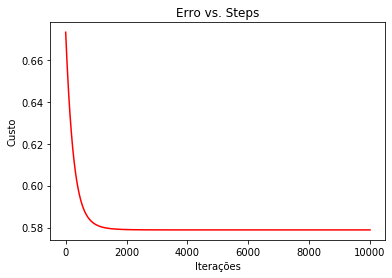

In [12]:
alpha=0.01 # taxa de aprendizado
nsteps = 10000
w, cost = gradient_descent(w, X, y, alpha, nsteps)
fig, ax = plt.subplots()  
ax.plot(np.arange(nsteps), cost, 'r')  
ax.set_xlabel('Iterações')  
ax.set_ylabel('Custo')  
ax.set_title('Erro vs. Steps')  

Vamos ver os coeficientes otimizados pela técnica do gradiente:

In [13]:
print('W_0={}, W_1={}, W_2={}, W_3={}'.format(w[0,0],w[0,1],w[0,2],w[0,3]))

W_0=0.08189974259455159, W_1=1.0313304195461113, W_2=-0.23579774583488436, W_3=0.43191877839286974


Vamos ver a sigmoid ajustada aos dados de SASDI (ano 0):

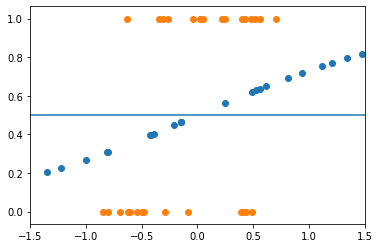

In [14]:
sig_ajusted=sigmoid(X @ w.T)
xl=np.array(X @ w.T)
fig, ax = plt.subplots(figsize=(6,4))  
ax.scatter(xl, sig_ajusted)
ax.plot([-2,2],[0.5,0.5])
ax.set_xlim([-1.5,1.5])

ax.scatter(sasdi,Y)


#plt.show()
#sns.scatterplot(x='SASDI',y='NINO3',data=df,hue='Tanom')

<hr>

<h1> Muito legal! </h1>

Vou refazer a Regressão Logistica, agora com a biblioteca do statsmodels para obtermos algumas informações estatísticas relevantes:

In [15]:
modelo = smf.glm(formula='Tanom ~ SASDIy0 + SASDIy1+ NINO3', data=df,
                family = sm.families.Binomial()).fit()
print(modelo.summary())
#print(modelo.pvalues[1])


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Tanom   No. Observations:                   29
Model:                            GLM   Df Residuals:                       25
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.787
Date:                Wed, 23 Feb 2022   Deviance:                       33.574
Time:                        17:56:13   Pearson chi2:                     29.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1089      0.518     -0.210      0.8

<strong>Notemos:</strong>

- a variável que mais explicou o comportamento das anomalias de temperatura sobre São Paulo, entre JJA, foi justamente o SASDIy0, que é justamente o procursor do SASD Memory Effect. 

In [16]:
model = LogisticRegression(penalty='none', solver='newton-cg')
baseline_df = df[['Tanom', 'SASDIy0', 'SASDIy1' ,'NINO3']].dropna()
y = baseline_df.Tanom
X = pd.get_dummies(baseline_df[['SASDIy0', 'SASDIy1','NINO3']], drop_first=True)
#print(X)

In [17]:
model.fit(X, y)
#print(model.coef_) # Temos o mesmo modelo!


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:


# Predizendo as probabilidades
#yhat = model.predict_proba(X)
#yhat
#yhat = yhat[:, 1] # manter somente para a classe positiva



In [19]:
confusion_matrix(y, model.predict(X))

array([[10,  4],
       [ 5, 10]])

In [20]:
acuracia = accuracy_score(y, model.predict(X))
print('O modelo obteve %0.4f de acurácia.' % acuracia)
print(classification_report(y, model.predict(X)))


O modelo obteve 0.6897 de acurácia.
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        14
           1       0.71      0.67      0.69        15

    accuracy                           0.69        29
   macro avg       0.69      0.69      0.69        29
weighted avg       0.69      0.69      0.69        29



<hr>
<strong>Acurácia</strong> : Indica a performace geral do modelo de classificação. Dentre todos os eventos, quantos o modelo classificou corretamente 

$$acurácia =\frac{TP+TN}{FP+TP+FN+TN}$$

<strong>Precisão </strong>: Dentre todos os eventos positivos, quantos o modelo acertou sua classificação.

$$precisao =\frac{TP}{FP+TP}$$


<strong>Recall</strong>: A proporção das classificações Positivas que foram corretamente identificadas
$$recall =\frac{TP}{FN+TP}$$



<h1>Conclusões</h1>

Observamos que, dentro do conjunto de treinamento, o modelo apresentou valores de acurácia, precisão e recall de aproximadamente 70%. Embora ENSO e SASD sejam conhecidos por seus efeitos no clima regional, o modelo regressor apontou para o SASDI_y0 como seu principal componente. Esses resultados evidenciam a importancia do SASD memory effect para o clima regional do sudeste brasileiro, e seu real potencial na aplicação como indicador preditivo.
